In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt


In [2]:
class Generator(nn.Module):
    def __init__(self, latent_dim, output_dim):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            nn.Linear(128, output_dim),
            nn.Softmax(dim=1)  # troque nn.Tanh() por nn.Softmax(dim=1)
        )

    def forward(self, x):
        return self.model(x)


In [3]:
class Discriminator(nn.Module):
    def __init__(self, input_dim):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )
        self.output = nn.Sigmoid()

    def forward(self, x):
        x = self.model(x)
        return self.output(x)



In [4]:
def generate_latent_points(latent_dim, n_samples):
    return torch.randn(n_samples, latent_dim)

def get_stock_data(tickers, start_date, end_date):
    data = yf.download(tickers, start=start_date, end=end_date)['Adj Close']
    return data

def prepare_data(stock_data):
    normalized_data = stock_data / stock_data.iloc[0]
    tensor_data = torch.Tensor(normalized_data.values)
    return tensor_data, stock_data.pct_change().dropna()

def generate_portfolios(generator, latent_dim, n_samples):
    latent_points = generate_latent_points(latent_dim, n_samples)
    return generator(latent_points)

In [5]:
def train_discriminator(discriminator, real_data, fake_data, optimizer, criterion):
    real_labels = torch.ones(real_data.size(0), 1)
    fake_labels = torch.zeros(fake_data.size(0), 1)
    discriminator.train()
    optimizer.zero_grad()
    real_output = discriminator(real_data)
    fake_output = discriminator(fake_data)
    real_loss = criterion(real_output, real_labels)
    fake_loss = criterion(fake_output, fake_labels)
    loss = real_loss + fake_loss
    loss.backward()
    optimizer.step()


In [6]:
def calculate_portfolio_performance(weights, returns):
    portfolio_return = np.sum(returns.mean() * weights) * 252
    portfolio_std_dev = np.sqrt(np.dot(weights.T, np.dot(returns.cov() * 252, weights)))
    return portfolio_return, portfolio_std_dev

In [7]:
def train_gan(generator, discriminator, latent_dim, n_epochs, n_batch, real_data, returns, optimizer_d, optimizer_g):
    criterion = nn.BCELoss()
    portfolio_performance = []
    
    for epoch in range(n_epochs):
        for _ in range(n_batch):
            fake_data = generate_portfolios(generator, latent_dim, real_data.shape[0])
            train_discriminator(discriminator, real_data, fake_data, optimizer_d, criterion)
        
        discriminator.eval()
        optimizer_g.zero_grad()
        noise = generate_latent_points(latent_dim, real_data.shape[0])
        generated_data = generator(noise)
        output = discriminator(generated_data)
        gen_loss = criterion(output, torch.ones(real_data.shape[0], 1))
        gen_loss.backward()
        optimizer_g.step()

        for data in generated_data:
            weights = data.detach().numpy().flatten()
            ret, risk = calculate_portfolio_performance(weights, returns)
            portfolio_performance.append((ret, risk))
    
    return portfolio_performance

In [8]:
# Hiperparâmetros
latent_dim = 10
n_epochs = 100
n_batch = 64
tickers = ['PETR4.SA', 'ENEV3.SA', 'UGPA3.SA','VALE3.SA','ITUB4.SA', 'BBAS3.SA', 'BBDC4.SA','MGLU3.SA', 'VIIA3.SA','JBSS3.SA', 'BRFS3.SA','ABEV3.SA']
start_date = '2018-07-09'
end_date = '2023-07-09'

# Obtenha os dados históricos das ações
stock_data = get_stock_data(tickers, start_date, end_date)

# Prepare os dados históricos das ações para treinamento
input_dim = len(tickers)
output_dim = len(tickers)
                 

prepared_data, returns = prepare_data(stock_data)

[*********************100%***********************]  12 of 12 completed


In [9]:
discriminator = Discriminator(input_dim)
generator = Generator(latent_dim, output_dim)

optimizer_d = optim.Adam(discriminator.parameters(), lr=0.001)
optimizer_g = optim.Adam(generator.parameters(), lr=0.001)

portfolio_performance = train_gan(generator, discriminator, latent_dim, n_epochs, n_batch, prepared_data, returns, optimizer_d, optimizer_g)


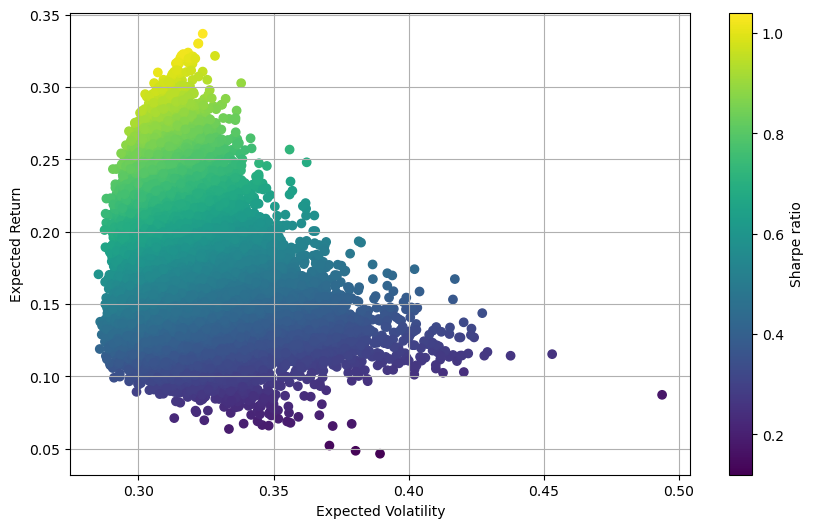

PETR4.SA: 0.09556704014539719
ENEV3.SA: 0.11689548939466476
UGPA3.SA: 0.006169669330120087
VALE3.SA: 0.23253262042999268
ITUB4.SA: 0.02204575203359127
BBAS3.SA: 0.012072788551449776
BBDC4.SA: 0.18080812692642212
MGLU3.SA: 0.017034195363521576
VIIA3.SA: 0.01406364981085062
JBSS3.SA: 0.006956443190574646
BRFS3.SA: 0.2100522667169571
ABEV3.SA: 0.08580184727907181


In [10]:
returns, risks = zip(*portfolio_performance)

plt.figure(figsize=(10, 6))
plt.scatter(risks, returns, c=np.array(returns) / np.array(risks), marker='o')
plt.grid(True)
plt.xlabel('Expected Volatility')
plt.ylabel('Expected Return')
plt.colorbar(label='Sharpe ratio')
plt.show()

generator.eval()
generated_portfolio = generate_portfolios(generator, latent_dim, 1)

portfolio_weights = generated_portfolio.detach().numpy().flatten()

for i, ticker in enumerate(tickers):
    print(f"{ticker}: {portfolio_weights[i]}")

In [11]:
# Obtendo os pesos do portfólio gerado
portfolio_weights = generated_portfolio.detach().numpy().flatten()

# Exibindo os pesos atribuídos a cada ação
for i, ticker in enumerate(tickers):
    print(f"{ticker}: {portfolio_weights[i]}")

PETR4.SA: 0.09556704014539719
ENEV3.SA: 0.11689548939466476
UGPA3.SA: 0.006169669330120087
VALE3.SA: 0.23253262042999268
ITUB4.SA: 0.02204575203359127
BBAS3.SA: 0.012072788551449776
BBDC4.SA: 0.18080812692642212
MGLU3.SA: 0.017034195363521576
VIIA3.SA: 0.01406364981085062
JBSS3.SA: 0.006956443190574646
BRFS3.SA: 0.2100522667169571
ABEV3.SA: 0.08580184727907181
